# Fluorescence images of micro-algeas

In [535]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from torchvision.utils import save_image
import torchvision
from skimage import io


## Load the image

PIL and Matplotlib fail, scikit-image works
The image is a stack of several monochrome photographies, all from the same view points.
Between different timestep, the photoluminescence varies.


In [536]:
tiff_file = "data.tiff"

# tiff_img = Image.open(tiff_file)
# display(tiff_img)
# np_img = np.array(tiff_img)

# np_img = plt.imread(tiff_file)
# display(np_img)

tif = io.imread(tiff_file) # open tiff file in read mode


## Filter out failed photographies

Some images are completely black due to the capture device.

In [537]:
max_per_timestep = tif.max(1).max(1)
keep_image = max_per_timestep > 0
photo_index = np.arange(len(keep_image))[keep_image]
tif = tif[keep_image]

## Apply a gaussian filter to remove the sensor noise

We use a kernel of size 3x3. We could also smooth temporally but this is sufficient

In [538]:
blurrer = torchvision.transforms.GaussianBlur(3, sigma=(1))
tif_blurred = blurrer(torch.from_numpy(tif.astype(np.float32)))

## Visualizing the data
We look at the first five images

Shape torch.Size([724, 480, 640])


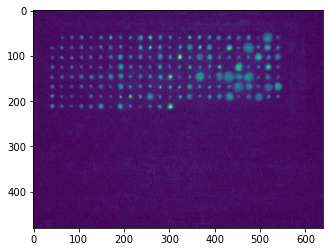

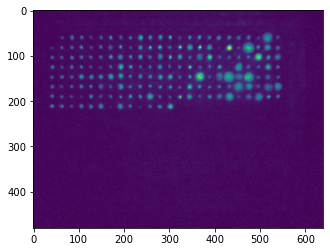

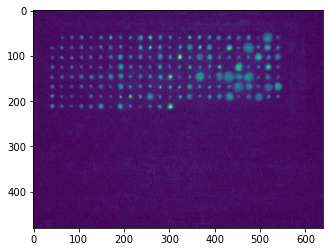

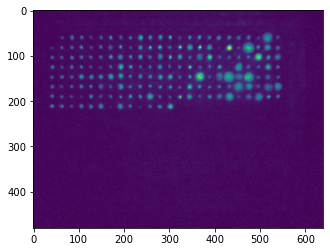

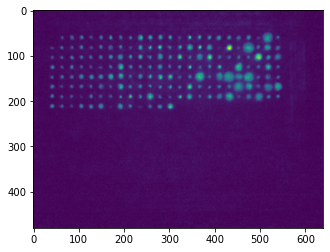

In [539]:
# show all images in tiff file
print("Shape", tif_blurred.shape)
for i in range(5):
    plt.imshow(tif_blurred[i,:,:])
    plt.show()

## Hyperparameters of the approach

We hardcode the position of the cells in the image. They could be detected, but the capture environment is sufficiently constrained.

In [540]:
x_min = 60
x_max = 212
y_min = 42
y_max = 540
num_timesteps = tif.shape[0]
num_rows = 8
num_columns = 24
width_x = int(np.floor((x_max  - x_min) / (num_rows - 1) / 2)) 
width_y = int(np.floor((y_max  - y_min) / (num_columns - 1) / 2))  
print(width_x, width_y)

10 10


### Visualize the crops we defined around the cells

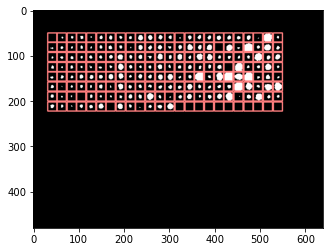

In [541]:
img = tif_blurred[0,:,:]
work_img = 255 * (img.clone() > 35)
# Mark this coordinate on the image
import cv2

_GOLD = (255, 127, 127)
_GREEN = (0, 127, 0)

def draw_mark(cv_src, pts, pts2, color=_GOLD):
    cv2.rectangle(
            cv_src, pts , pts2, color=_GOLD, thickness=2)


img.max(), img.min()
torch_img = work_img
torch_img = torch_img.unsqueeze(0).repeat(3, 1, 1)
input_img = torch_img.permute(1, 2, 0).contiguous().numpy().astype(np.int16)


x = torch.linspace(x_min, x_max, num_rows)
y = torch.linspace(y_min, y_max, num_columns)

a, b = torch.meshgrid(x, y)
a,b = a.int(), b.int()
for i in range(a.shape[0]):
    for j in range(a.shape[1]):
        pts = (b[i,j].item() -  width_x, a[i,j].item() -  width_y)
        pts2 = (b[i,j].item() +  width_x, a[i,j].item() +  width_y)
        draw_mark(input_img, pts, pts2, color=_GREEN)


save_image(torch.from_numpy(input_img).float().permute(2,0,1), "input_img.png")
plt.imshow(input_img)





## Crop the images and the blurred images

In [542]:
crops = torch.Tensor(size=(num_timesteps, num_rows, num_columns, 2*int(width_x)+1, 2*int(width_y)+1))
crops_blurred = torch.Tensor(size=(num_timesteps, num_rows, 2*num_columns, 2*int(width_x)+1, 2*int(width_y)+1))
input_img = torch.from_numpy(tif.astype(np.float32))
input_img_blurred = tif_blurred
for i in range(a.shape[0]):
    for j in range(a.shape[1]):
        # print(i,j, int(a[i,j] - width_x / 2), int(a[i,j] + width_x / 2), int(b[i,j] - width_y / 2), int(b[i,j] + width_y / 2))
        pts = (a[i,j].item(), b[i,j].item())
        crops[:,i,j] = input_img[:, int(a[i,j] - width_x): int(a[i,j] + width_x + 1), int(b[i,j] - width_y): int(b[i,j] + width_y + 1)].contiguous()
        crops_blurred[:,i,j] = input_img_blurred[:, int(a[i,j] - width_x): int(a[i,j] + width_x + 1), int(b[i,j] - width_y): int(b[i,j] + width_y + 1)].contiguous()
crops = crops.contiguous()    
crops_blurred = crops_blurred.contiguous()    

## Estimate Noise

We use the first crop, which is without cells, to evaluate the noise level of the capture device. We threshold everything below mean + 3 std as irrelevant.

mean : 4.838316440582275, std 6.174421310424805, threshold 23.36157989501953


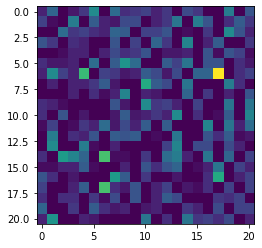

In [543]:
plt.imshow(crops[0,0,0])
mean = crops[:,0,0].mean()
std = crops[:,0,0].std()
THRESHOLD = mean + 3 * std
print(f"mean : {mean}, std {std}, threshold {THRESHOLD}")


# Create masks per crop
For each crop, we compute the minimum over the time steps and threshold it.
This means that within the resulting mask, the is relevant signal in every image.

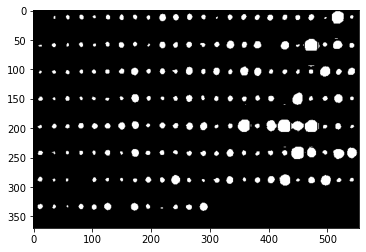

In [544]:
masks = crops_blurred.min(0)[0] > THRESHOLD
mask_log = masks.float().view(-1,masks.shape[2], masks.shape[3]).float().unsqueeze(1)
save_image(mask_log, "masks.png", nrow=num_columns)

np_img = plt.imread("masks.png")
plt.imshow(np_img)

## Shrink masks to avoid contagion effects.

Some cells are too big and might contiminate their neighbourg. We compute the intersection of the masks with a predefined smaller disk mask to avoid the contaminated signal.

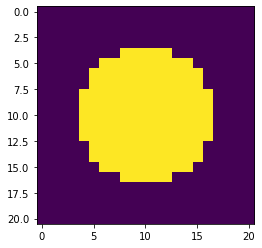

In [545]:
# Create a disk-like mask
sphere = torch.zeros(size=(2*int(width_x)+1, 2*int(width_y)+1))
for i in range(sphere.shape[0]):
    for j in range(sphere.shape[1]):
        if (i - width_x)**2 + (j - width_y)**2 < ((2.0/3.0) * width_x)**2:
            sphere[i,j] = 1
plt.imshow(sphere)

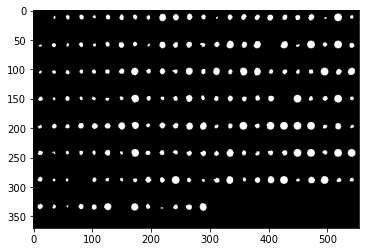

In [546]:
# Compute the intersection of the masks with the disk
masks_shrunk = masks * sphere.unsqueeze(0).unsqueeze(0).unsqueeze(0)
mask_log = masks_shrunk.float().view(-1,masks.shape[2], masks.shape[3]).float().unsqueeze(1)
save_image(mask_log, "masks_shrunk.png", nrow=num_columns)
np_img = plt.imread("masks_shrunk.png")
plt.imshow(np_img)